In [1]:
from transformers import AutoTokenizer
from decord import VideoReader, cpu
from PIL import Image
from vllm import LLM, SamplingParams

MODEL_NAME = "openbmb/MiniCPM-V-2_6"  # or local model path
llm = LLM(
    model=MODEL_NAME,
    gpu_memory_utilization=0.95,
    max_model_len=4096,
    trust_remote_code=True
)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
stop_tokens = ['<|im_end|>', '<|endoftext|>']
stop_token_ids = [tokenizer.convert_tokens_to_ids(i) for i in stop_tokens]


INFO 02-14 17:21:26 __init__.py:190] Automatically detected platform cuda.
INFO 02-14 17:21:32 config.py:542] This model supports multiple tasks: {'embed', 'classify', 'reward', 'generate', 'score'}. Defaulting to 'generate'.
INFO 02-14 17:21:32 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.2) with config: model='openbmb/MiniCPM-V-2_6', speculative_config=None, tokenizer='openbmb/MiniCPM-V-2_6', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]


INFO 02-14 17:21:36 model_runner.py:1115] Loading model weights took 15.1923 GB


/home/uliege/miniconda3/envs/isaaclab/lib/python3.10/site-packages/transformers/models/auto/image_processing_auto.py:590: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


INFO 02-14 17:21:41 worker.py:267] Memory profiling takes 4.87 seconds
INFO 02-14 17:21:41 worker.py:267] the current vLLM instance can use total_gpu_memory (23.54GiB) x gpu_memory_utilization (0.95) = 22.37GiB
INFO 02-14 17:21:41 worker.py:267] model weights take 15.19GiB; non_torch_memory takes 0.10GiB; PyTorch activation peak memory takes 3.99GiB; the rest of the memory reserved for KV Cache is 3.09GiB.
INFO 02-14 17:21:41 executor_base.py:110] # CUDA blocks: 3617, # CPU blocks: 4681
INFO 02-14 17:21:41 executor_base.py:115] Maximum concurrency for 4096 tokens per request: 14.13x
INFO 02-14 17:21:42 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utilization` or switching to eager mode. You can also reduce the `max_num_seqs` as

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:07<00:00,  4.42it/s]

INFO 02-14 17:21:50 model_runner.py:1562] Graph capturing finished in 8 secs, took 0.17 GiB
INFO 02-14 17:21:50 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 14.32 seconds


In [14]:
# Function to encode video into a list of frames
MAX_NUM_FRAMES = 16
def encode_video(filepath):
    def uniform_sample(l, n):
        gap = len(l) / n
        idxs = [int(i * gap + gap / 2) for i in range(n)]
        return [l[i] for i in idxs]
    
    vr = VideoReader(filepath, ctx=cpu(0))
    sample_fps = round(vr.get_avg_fps() / 1)  # FPS
    frame_idx = [i for i in range(0, len(vr) // 2, sample_fps)]
    
    if len(frame_idx) > MAX_NUM_FRAMES:
        frame_idx = uniform_sample(frame_idx, MAX_NUM_FRAMES)

    frame_idx += [2.5 * len(vr) // 4]
    
    video = vr.get_batch(frame_idx).asnumpy()
    video = [Image.fromarray(v.astype('uint8')) for v in video]
    return video

In [22]:

task = "Go to the cliff."
frames = encode_video("xxx.mp4")
messages = [{
    "role": "user",
    "content": "".join(["(<video>./</video>)"]) + f"Given the task: '{task}'. Estimate the completion of the task in percentage in the last frame given.\nThink step by step then answer.\n Use the format: Percent=X%."
}]

prompt = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)

sampling_params = SamplingParams(
    stop_token_ids=stop_token_ids, 
    temperature=0,
    max_tokens=512
)

outputs = llm.generate({
    "prompt": prompt,
    "multi_modal_data": {
        "video": frames
    }
}, sampling_params=sampling_params)

print(outputs[0].outputs[0].text)

Processed prompts: 100%|██████████| 1/1 [00:06<00:00,  6.19s/it, est. speed input: 190.41 toks/s, output: 56.20 toks/s]

To estimate the completion of the task in the last frame, we need to consider the sequence of frames and the progression of the task. The task is to 'go to the cliff,' which is a specific point of interest in the video.

1. The first frame shows a cliff with a clear view of the sea and sky.
2. The second frame continues to show the cliff and the sea, with a text overlay that might indicate a theme or title.
3. The third frame shows a building on the cliff, which could be a point of interest.
4. The fourth frame shows a different angle of the cliff, emphasizing its height and the surrounding landscape.
5. The fifth frame shows a closer view of the cliff, highlighting its rugged texture.
6. The sixth frame shows a different landscape, possibly indicating a change in location or a different part of the same area.
7. The seventh frame shows a coastal area with a bridge, which might be a point of interest.
8. The eighth frame shows a clear view of the sea and the cliff, with the sun reflect

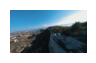

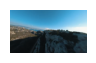

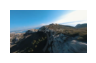

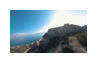

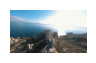

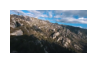

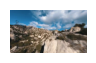

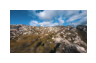

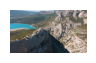

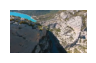

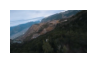

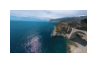

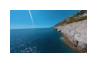

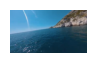

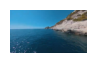

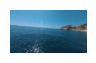

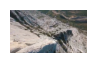

In [23]:
import matplotlib.pyplot as plt
for frame in frames:
    #display all frames in a matplotlib grid
    f = plt.figure(figsize=(20, 20))
    f.add_subplot(1, len(frames), 1)
    # remove axis and show image
    plt.axis('off')
    plt.imshow(frame)
    